In [2]:
from PIL import Image
from rl_benchmarks.models import iBOTViT
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
import pathlib
from tqdm import tqdm
from PIL import Image
import numpy as np
Image.MAX_IMAGE_PIXELS = None
from torchvision import transforms
import torch
from torch.utils.data import Dataset
import os
from multiprocessing import Pool
import umap
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from rl_benchmarks.utils.linear_evaluation import get_binary_class_metrics, get_bootstrapped_metrics, dict_to_dataframe
import umap.plot

/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
weights_path = '/home/yuxin/Downloads/ibot_vit_base_pancan.pth'
ibot_base_pancancer = iBOTViT(architecture="vit_base_pancan", encoder="student", weights_path=weights_path).to(device)

2023-11-27 17:40:20.080 | INFO     | rl_benchmarks.models.feature_extractors.ibot_vit:__init__:78 - Pretrained weights found at /home/yuxin/Downloads/ibot_vit_base_pancan.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['masked_embed', 'head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v', 'head.last_layer2.weight_g', 'head.last_layer2.weight_v'])


In [5]:
cohorts = ['SUQH', 'QDUH', 'SHSU']
cohort_root = pathlib.Path('/mnt/hd0/original_datasets/JT_Breast/jt_extract')
data_roots = {
    'SUQH': cohort_root / 'QiLu' / '10xAnnoRegionMaskExtract',
    'QDUH': cohort_root / 'QingDao' / '10xAnnoRegionMaskExtract_all',
    'SHSU': cohort_root / 'ShanDaEr' / '10xAnnoRegionMaskExtract'
}

save_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad')

In [10]:
patch_size = 224
data_trans = transforms.Compose([
                                transforms.CenterCrop(patch_size),
                                # transforms.Resize(patch_size),
                                ibot_base_pancancer.transform,
                                ])

In [11]:

for cohort in cohorts:
    data_root = data_roots[cohort]
    tile_paths = list(data_root.glob('**/*.png'))
    # exclude path if filename contains `mask`
    tile_paths = [path for path in tile_paths if 'mask' not in path.name]
    for path in tqdm(tile_paths, desc=f'Processing {cohort}'):
        save_path = save_root / cohort / path.parent.name / f'{path.stem}.npy' 
        save_path.parent.mkdir(exist_ok=True, parents=True)
        im = Image.open(path)
        tensor = data_trans(im)
        batch = tensor.unsqueeze(0)
        batch = batch.to(device)
        features = ibot_base_pancancer(batch).detach().cpu().numpy()
        np.save(save_path, features)
            


Processing SHSU: 100%|██████████| 527/527 [00:27<00:00, 19.38it/s]


In [15]:
def get_type_grade(path):
    name = path.stem
    splits = name.split('-')
    type = splits[-2]
    grade = splits[-1]
    if type=='ibc':
        type = 1
    else:
        type = 0
    grade = int(grade)-1
    return type, grade

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix, labels):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.title('Confusion Matrix')
    plt.show()

In [17]:
def get_metrics(labels, scores, class_names, phase='test'):
    n_resamples = 1000
    confidence_level = 0.95

    binary_metrics = {phase:get_binary_class_metrics(labels, scores)}
    bootstrapped_metrics = {phase: get_bootstrapped_metrics(
        labels, scores, n_resamples=n_resamples, confidence_level=confidence_level
    )}

    results_dict = {
        "binary": binary_metrics,
        "bootstrap": bootstrapped_metrics,
    }
    
    results = dict_to_dataframe(
        results_dict, metrics=["auc", "acc", "f1"], class_names=class_names
    )
    return results


In [24]:
ibc_features = {}
nonibc_features = {}
ibc_labels = {}
nonibc_labels = {}


for cohort in cohorts:
    feature_root = save_root / cohort
    feature_paths = list(feature_root.glob('**/*.npy'))
    _features = [np.load(path).flatten() for path in feature_paths]

    types, grades = zip(*[get_type_grade(path) for path in feature_paths])

    _ibc_features = [_features[i] for i in range(len(_features)) if types[i]==1]
    _nonibc_features = [_features[i] for i in range(len(_features)) if types[i]==0]
    _ibc_labels = [grades[i] for i in range(len(_features)) if types[i]==1]
    _nonibc_labels = [grades[i] for i in range(len(_features)) if types[i]==0]

    ibc_features[cohort] = _ibc_features
    nonibc_features[cohort] = _nonibc_features
    ibc_labels[cohort] = _ibc_labels
    nonibc_labels[cohort] = _nonibc_labels 

# Grading IBC-1 IBC-2 IBC-3

In [19]:
class_names = ['IBC 1', 'IBC 2', 'IBC 3']
# mapper = umap.UMAP(n_neighbors=50, min_dist=0.02).fit(features['train'] + features['val'])
# fig = plt.figure(figsize=(10, 10), dpi=100)
# umap.plot.points(mapper, 
#                  labels=np.array(class_names)[np.array(labels['grade']['train'] + labels['grade']['val'])], 
#                  theme='fire')

In [25]:
ibc_features['SUQH'][0].shape

(768,)

In [26]:
model1 = sklearn.linear_model.SGDClassifier(
                loss="log_loss",
                penalty="l2",
                learning_rate="adaptive",
                eta0=1e-4,
                n_jobs=8,
                early_stopping=False,
                random_state=2023,
            ).fit(np.array(ibc_features['SUQH']), np.array(ibc_labels["SUQH"]))

In [30]:
model1.score

<bound method ClassifierMixin.score of SGDClassifier(eta0=0.0001, learning_rate='adaptive', loss='log_loss', n_jobs=8,
              random_state=2023)>

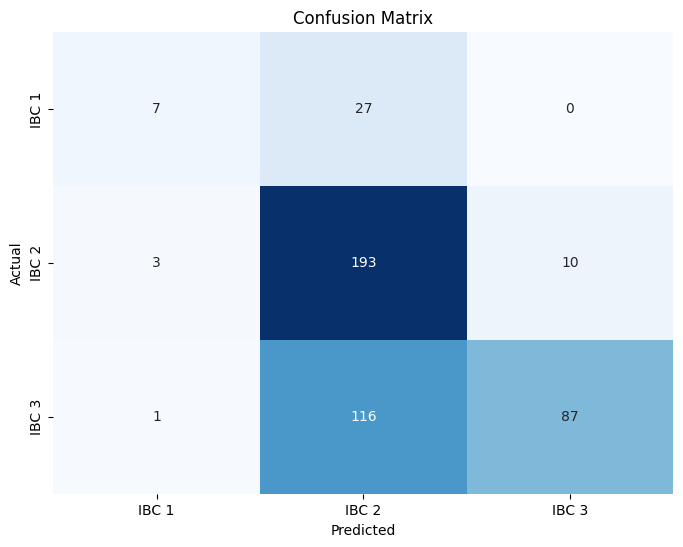

,0
portion,test
IBC 1_auc,0.895624
IBC 1_acc,0.93018
IBC 1_f1,0.311111
IBC 2_auc,0.737864
IBC 2_acc,0.648649
IBC 2_f1,0.712177
IBC 3_auc,0.830821
IBC 3_acc,0.713964
IBC 3_f1,0.578073


In [27]:
model = model1
cohort = 'QDUH'
test_scores = model.predict_proba(ibc_features[cohort])
test_preds = model.predict(ibc_features[cohort])
plot_confusion_matrix(confusion_matrix(ibc_labels[cohort], test_preds), class_names)
get_metrics(ibc_labels[cohort], test_scores, class_names).T

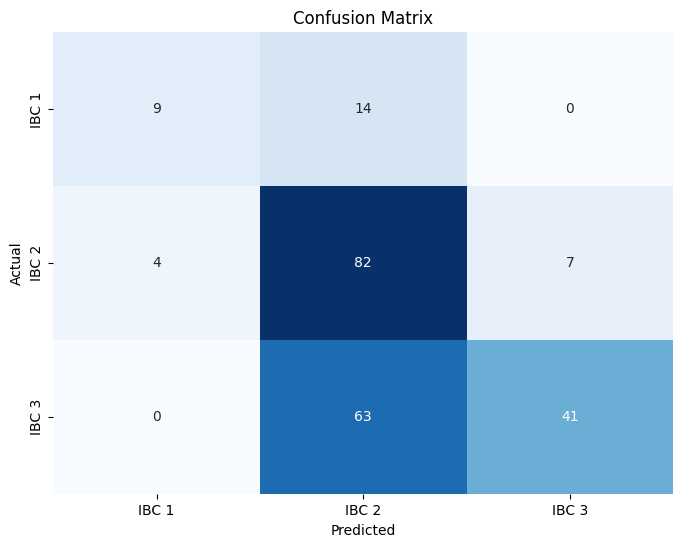

,0
portion,test
IBC 1_auc,0.919223
IBC 1_acc,0.918182
IBC 1_f1,0.5
IBC 2_auc,0.689019
IBC 2_acc,0.6
IBC 2_f1,0.650794
IBC 3_auc,0.797414
IBC 3_acc,0.681818
IBC 3_f1,0.539474


In [28]:
model = model1
cohort = 'SHSU'
test_scores = model.predict_proba(ibc_features[cohort])
test_preds = model.predict(ibc_features[cohort])
plot_confusion_matrix(confusion_matrix(ibc_labels[cohort], test_preds), class_names)
get_metrics(ibc_labels[cohort], test_scores, class_names).T

# Grading IBC-1 vs IBC-3

In [35]:
class_names = ['IBC-1', 'IBC-3']

In [33]:
g13_features = {}
g13_labels = {}
for cohort in cohorts:

    labels = ibc_labels[cohort]
    _labels = []
    _features = []
    for i in range(len(labels)):
        if labels[i] == 1:
            continue
        elif labels[i] == 0:
            _labels.append(0)
            _features.append(ibc_features[cohort][i])
        else:
            _labels.append(1)
            _features.append(ibc_features[cohort][i])
    g13_features[cohort] = _features
    g13_labels[cohort] = _labels


In [34]:


model2 = sklearn.linear_model.SGDClassifier(
                loss="log_loss",
                penalty="l2",
                learning_rate="adaptive",
                eta0=1e-4,
                n_jobs=8,
                early_stopping=False,
                random_state=2023,
            ).fit(np.array(g13_features['SUQH']), np.array(g13_labels["SUQH"]))

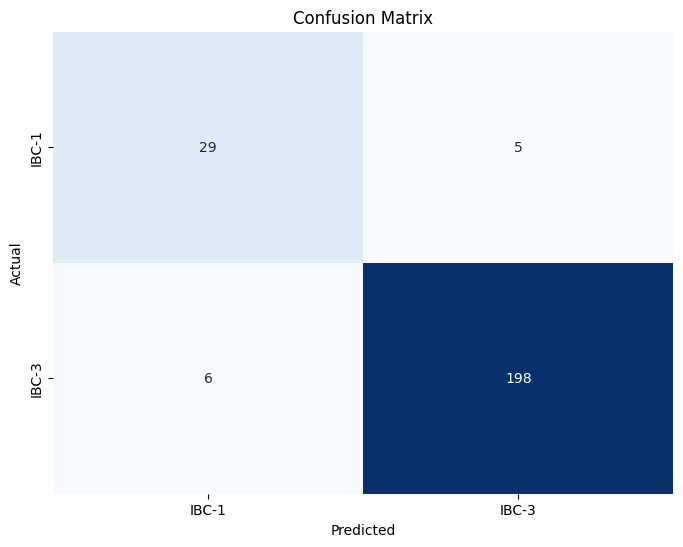

,0
portion,test
IBC-1_auc,0.987168
IBC-1_acc,0.953782
IBC-1_f1,0.84058
IBC-3_auc,0.987168
IBC-3_acc,0.953782
IBC-3_f1,0.972973
auc,0.987168
acc,0.953782
f1,0.972973


In [36]:
cohort = 'QDUH'
test_scores = model2.predict_proba(g13_features[cohort])
test_preds = model2.predict(g13_features[cohort])
plot_confusion_matrix(confusion_matrix(g13_labels[cohort], test_preds), class_names)
get_metrics(g13_labels[cohort], test_scores, class_names).T

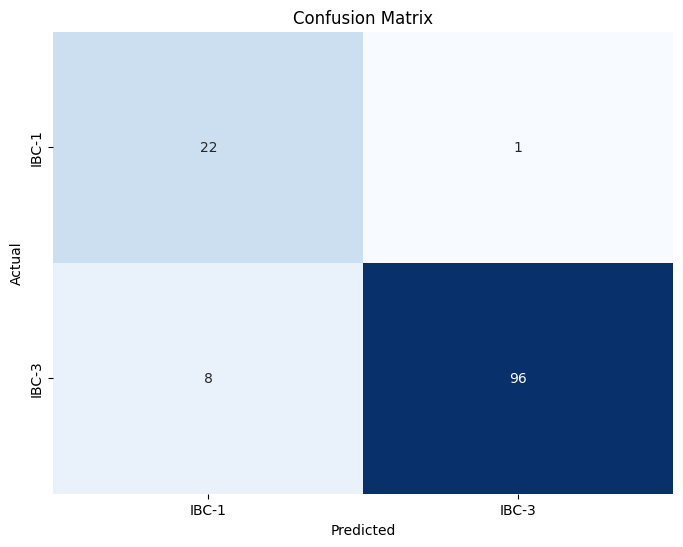

,0
portion,test
IBC-1_auc,0.976171
IBC-1_acc,0.929134
IBC-1_f1,0.830189
IBC-3_auc,0.976171
IBC-3_acc,0.929134
IBC-3_f1,0.955224
auc,0.976171
acc,0.929134
f1,0.955224


In [37]:
cohort = 'SHSU'
test_scores = model2.predict_proba(g13_features[cohort])
test_preds = model2.predict(g13_features[cohort])
plot_confusion_matrix(confusion_matrix(g13_labels[cohort], test_preds), class_names)
get_metrics(g13_labels[cohort], test_scores, class_names).T